In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../VT_SNN/")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from snn_models.baseline_snn import SlayerMLP
from snn_models.multimodal_snn import SlayerMM
from dataset import ViTacDataset, ViTacMMDataset
from torch.utils.data import DataLoader
import slayerSNN as snn

import torch
import pandas as pd
from os import listdir
from os.path import isfile, join
import copy
import seaborn as sns

device = torch.device("cuda:0")

In [3]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # activation threshold
        "tauSr": 10.0, # time constant for srm kernel
        "tauRef": 1.0, # refractory kernel time constant
        "scaleRef": 2, # refractory kernel constant relative to theta
        "tauRho": 1, # pdf
        "scaleRho": 1, # membrane potential 
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
}

net_tact = SlayerMLP(params, 156, 32, 2).to(device)
net_vis = SlayerMLP(params, (50, 63, 2), 32, 2).to(device)
net_mm = SlayerMM(params,2).to(device)

In [4]:
tact_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/9fabec7798a94750bacc09a89873c848/tac_weights_700_05.pt'
vis_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/eeb0be632c0c458cb228ee0a0f5b067b/vis_weights_500_05.pt'
mm_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/69a7a91be54d4eb0bdb3df3d36d7a2ea/mm_weights_500_04.pt'

# tact_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/1fb5f1ef21394fd9885c53fe4dc6ac52/tac_weights_700_05.pt'
# vis_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/db9f5129dffe423782370a789d4f5c5e/vis_weights_500_05.pt'
# mm_run_dir = '/home/tasbolat/tas_python_env/.guild/runs/8706a321646c49218aca6ae83d4d3fc9/mm_weights_500_05.pt'


data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN_new/slip_data/'

In [5]:
def load_model(path_to_model, model_type):
    if model_type == 'tac':
        net = copy.deepcopy(net_tact)
    elif model_type == 'vis':
        net = copy.deepcopy(net_vis)
    elif model_type == 'mm':
        net = copy.deepcopy(net_mm)
    
    net.load_state_dict(torch.load(path_to_model))
    return net

In [6]:
net_vis = load_model(vis_run_dir, 'vis')
net_vis.eval()

net_mm = load_model(mm_run_dir, 'mm')
net_mm.eval()

net_tact = load_model(tact_run_dir, 'tac')
net_tact.eval()

SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(156, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(32, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [7]:
sample_file = 5
test_dataset = ViTacMMDataset(
    path=data_dir, sample_file=f"test_80_20_{sample_file}.txt", output_size=20
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=80, shuffle=False, num_workers=4
)

In [8]:
import math

def quat_angle2(q1,q2):
    dotp=np.dot(q1,q2)/np.linalg.norm(q1)/np.linalg.norm(q2)
    return np.arccos(dotp)/math.pi*180

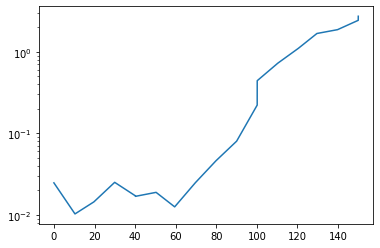

In [9]:
recording = np.loadtxt("rotate_03.worldobj")
rec_len = recording.shape[0]
time_vec = recording[:,1] + recording[:,2] * 10**-9
time_vec -= time_vec[0]
abs_angle = np.array([quat_angle2(recording[0,6:10],recording[i,6:10]) for i in range(rec_len)])
plt.plot((time_vec[124:143]-time_vec[124]) * 1000, abs_angle[124:143])
plt.yscale("log")

In [10]:
def plot_spikes(example, model_type):
    tact, vis, _, label = example
    input_index = 0
    tact = tact.unsqueeze(0).to(device="cuda")
    vis = vis.unsqueeze(0).to(device="cuda")
    if model_type == 'vis':
        out_spike = net_vis.forward(vis)
    elif model_type == 'tac':
        out_spike = net_tact.forward(tact)
    else:
        out_spike = net_mm.forward(tact, vis)
        
    ss = out_spike.squeeze().detach().cpu().numpy()
    lab = np.argmax(np.sum(ss, axis=1))
    return ss, lab

In [11]:
example = 6
output_spikes = {}
labels = {}
for mode_type in ['tac', 'vis', 'mm']:
    _, _, _,label = test_dataset[example]
    output_spikes[mode_type], _ = plot_spikes(test_dataset[example], mode_type)

In [12]:
print(label)

0


In [13]:
import pickle
pickle.dump(output_spikes, open('slip_output_L_negative.pkl', 'wb'))

In [14]:
output_spikes

{'tac': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0

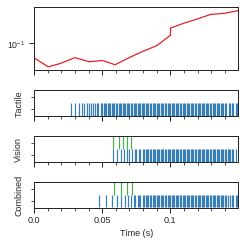

In [15]:
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True, 'font.sans-serif': 'Liberation Sans'},context='paper',
        style='white', palette='Set1')
fig, ax = plt.subplots(figsize=[3.5, 3.5], nrows=4, sharex=True, gridspec_kw={'height_ratios': [2.5, 1, 1, 1]})
# ax = ax.tolist()
# ax = [ax[3]] + ax[:3]
cols = [sns.palettes.color_palette('Set1')[1], sns.palettes.color_palette('Set1')[0], sns.palettes.color_palette('Set1')[2]]
cols_tact = [cols[0]] * 1 + [cols[1]]
cols_corr = [cols[0]] * 1 + [cols[2]]
ax[1].eventplot([np.argwhere(output_spikes['tac'][i] == 1).flatten() for i in range(2)], colors=cols_corr)
plt.xticks(np.arange(0, 150, 50), np.arange(0, 150, 50) * (0.15/150))
# ax[1].set_xticks(np.arange(0, 150, 10), minor=True)
# ax[1].tick_params(axis='x', which='minor')
ax[1].tick_params(labelsize=12)
ax[2].eventplot([np.argwhere(output_spikes['vis'][i] == 1).flatten() for i in range(2)], colors=cols_corr)
ax[3].eventplot([np.argwhere(output_spikes['mm'][i] == 1).flatten() for i in range(2)], colors=cols_corr)
plt.xticks(np.arange(0, 150, 50), np.arange(0, 150, 50) * (0.15/150))
ax[2].set_xticks(np.arange(0, 150, 10), minor=True)
ax[2].tick_params(axis='x', which='minor')
ax[1].set_ylim([-0.5, 1.5])
ax[2].set_ylim([-0.5, 1.5])
ax[3].set_ylim([-0.5, 1.5])
plt.xlim([0, 150])
ax[2].set_yticks([])
ax[1].set_yticks([])
ax[3].set_yticks([])
# plot.yticks(np.arange(0.4, 1.1, .1))
ax[2].tick_params(labelsize=12)
ax[1].set_ylabel('Tactile', fontsize=9)
ax[2].set_ylabel('Vision', fontsize=9)
ax[3].set_ylabel('Combined', fontsize=9)

ax[1].set_yticks(np.arange(0, 2, 1), minor=True)
ax[1].tick_params(axis='y', which='minor')
ax[2].set_yticks(np.arange(0, 2, 1), minor=True)
ax[2].tick_params(axis='y', which='minor')
ax[3].set_yticks(np.arange(0, 2, 1), minor=True)
ax[3].tick_params(axis='y', which='minor')


ax[0].plot((time_vec[124:143]-time_vec[124]) * 1000, abs_angle[124:143])
ax[0].set_yscale("log")

ax[3].tick_params(labelsize=9)
plt.xticks(fontsize=9)
# plot.yticks(fontsize=12)
plt.xlabel('Time (s)', fontsize=9)
# plot.ylabel('Tactile Spikes', fontsize=14)
plt.tight_layout()
plt.savefig('slip_class_output_new_L_w.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
output_spikes['tac'][0].shape

(150,)